<a href="https://colab.research.google.com/github/stp511/HealthPredictionProject2/blob/main/Updated_12_2_22_StevenPhillips_Project2_Part4_StrokePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 2 Part 4 - Stroke Predictions**
- **Steven Phillips**
- (Updated) December 2, 2022

The goal of this project will be to use the data set and create a best model for predicting the presence of stroke in patients.

## **Import Libraries, Load, Copy and Explore Data**


In [ ]:
#import seaborn, matplotlib and the pandas and numpy library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

# feature engineering, pipelines, and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA

# metrics
from sklearn.metrics import  precision_score, recall_score, accuracy_score, f1_score, \
       confusion_matrix, ConfusionMatrixDisplay, classification_report

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier


In [ ]:
#mount data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the data for Stroke Prediction Data Set csv file as a data frame, copy the data frame and present the first five rows
filename = '/content/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)
df_ml = df.copy()
df_ml.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## **Project 2 - Part 1 Questions**

1. Source of Data
2. Brief description of data
3. What is the target?
4. What does one row represent?
5. Is this a regression or classification problem?
6. How many features does the data have?
7. How many rows in the data set?
8. What, if any, challenges do you foresee in cleaning, exploring, or modeling with this dataset?

### **1. Source of data**

1. The source of this data is the Kaggle website and here is the link:

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### **2. Brief description of data**

"This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient." 

Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### **3. What is the target?**

The target for this data set will be the 'stroke' feature.  Specifically, whether or not each patient had a stroke.

### **4. What does one row represent?**

Each row represents a patient from the study.

### **5. Is this a regression or a classification problem?**

The model will predict the stroke feature, which is a binary classification problem, 'stroke' or 'no stroke'.

### **6. How many features does the data have?**

The data comes with 12 features, as seen in the first five rows of the data frame above.  However, the first feature, essentially the patient id, will not be used in modeling.  So there will be 10 features, including a mix of categorical and numerical, to choose from and one target feature.

### **7. How many rows in the data set?**

There are 5,110 observations or rows.

In [ ]:
# shape of the data  (rows, columns)
df_ml.shape

(5110, 12)

### **8. What, if any, challenges do you foresee in cleaning, exploring, or modeling with this dataset?**

There are a few issues that present challenges.  Choosing the best classification model will be a challenge.  Initially, cleaning the data set will have issues including dealing with missing entries from the bmi feature and checking the naming is consistent for the object data type features.

In [ ]:
# missing data by feature
df_ml.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## **Project 2 - Part 2 Clean and Explore the Data Set**

## **Data Cleaning**

**Be sure to address:**
- delete unnecessary columns
- delete duplicate rows
- identify and address missing values
- identify and correct inconsistencies in data for categorical values


In [ ]:
# check number of unique values by feature
df_ml.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

### **'id' unnecessary for analysis and will be dropped here:**

In [ ]:
# drop 'id' feature
df_ml = df_ml.drop(columns = ['id'])


### **No duplicated rows to address:**

In [ ]:
# check for duplicate rows
df_ml.duplicated().sum()

0

### **Check for missing values:**

In [ ]:
df_ml.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

'bmi' missing 201 values: Imputing the mean bmi into the 201 missing values will occur later during preprocessing.

In [ ]:
# Check categories for inconsistencies

for col in df_ml.select_dtypes('object'):
  print(f'{df_ml[col].value_counts()} \n')

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 

Yes    3353
No     1757
Name: ever_married, dtype: int64 

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 



In [ ]:
# drop the single row containing 'gender' value = 'Other' 
df_ml = df_ml[df_ml.gender != 'Other']

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


## **Exploratory Visuals**

- univariate visuals for the target and all features
- outlier exploration

### **'stroke' bar graph:**

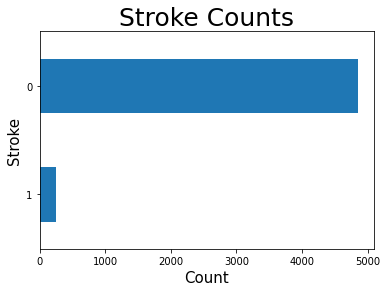

In [ ]:
#create a 'stroke' counts bar graph
stroke_counts = df_ml['stroke'].value_counts().sort_values()

# Plot the counts of each stroke level

stroke_counts.plot(kind = 'barh')
plt.title('Stroke Counts', fontsize = 25)
plt.ylabel('Stroke', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'gender' bar graph:**

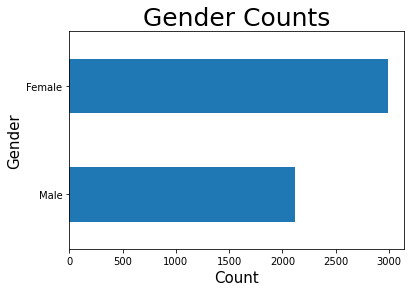

In [ ]:
#create a 'gender' counts bar graph
gender_counts = df_ml['gender'].value_counts().sort_values()

# Plot the counts of each gender level

gender_counts.plot(kind = 'barh')
plt.title('Gender Counts', fontsize = 25)
plt.ylabel('Gender', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'ever-married' bar graph:**

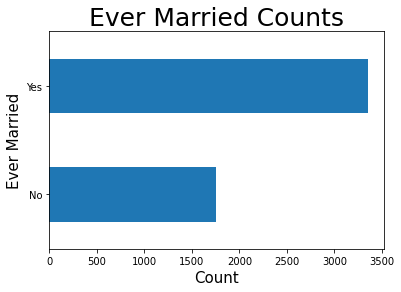

In [ ]:
#create a 'ever_married' counts bar graph
marriage_counts = df_ml['ever_married'].value_counts().sort_values()

# Plot the counts of each marriage level

marriage_counts.plot(kind = 'barh')
plt.title('Ever Married Counts', fontsize = 25)
plt.ylabel('Ever Married', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'work_type' bar garph:**

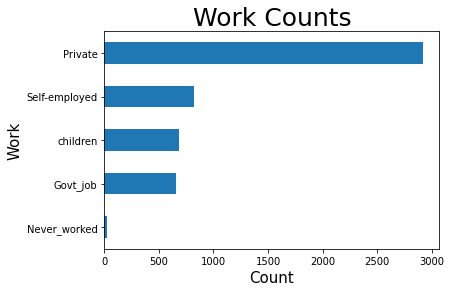

In [ ]:
#create a 'work_type' counts bar graph
work_counts = df_ml['work_type'].value_counts().sort_values()

# Plot the counts of each work type level

work_counts.plot(kind = 'barh')
plt.title('Work Counts', fontsize = 25)
plt.ylabel('Work', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'Residence_type' bar graph:**

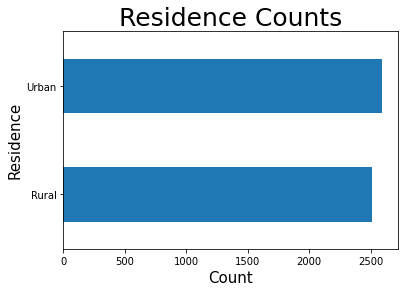

In [ ]:
#create a 'residence_type' counts bar graph
residence_counts = df_ml['Residence_type'].value_counts().sort_values()

# Plot the counts of each residence type level

residence_counts.plot(kind = 'barh')
plt.title('Residence Counts', fontsize = 25)
plt.ylabel('Residence', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'smoking_status' bar graph:**

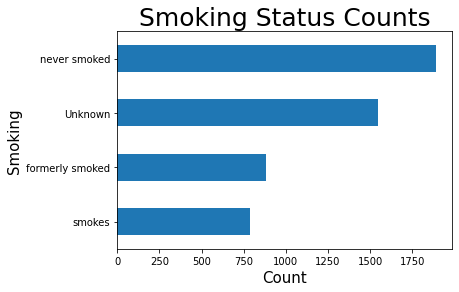

In [ ]:
#create a 'smoking_status' counts bar graph
smoking_counts = df_ml['smoking_status'].value_counts().sort_values()

# Plot the counts of each smoking status level

smoking_counts.plot(kind = 'barh')
plt.title('Smoking Status Counts', fontsize = 25)
plt.ylabel('Smoking', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'heart_disease' bar graph:**

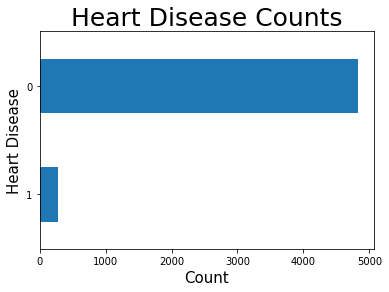

In [ ]:
#create a 'heart_disease' counts bar graph
heartdisease_counts = df_ml['heart_disease'].value_counts().sort_values()

# Plot the counts of each heart disease level

heartdisease_counts.plot(kind = 'barh')
plt.title('Heart Disease Counts', fontsize = 25)
plt.ylabel('Heart Disease', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'hypertension' bar graph:**

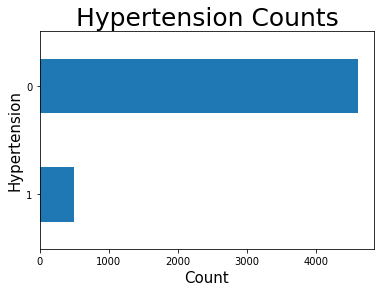

In [ ]:
#create a 'hypertension' counts bar graph
hypertension_counts = df_ml['hypertension'].value_counts().sort_values()

# Plot the counts of each heart disease level

hypertension_counts.plot(kind = 'barh')
plt.title('Hypertension Counts', fontsize = 25)
plt.ylabel('Hypertension', fontsize = 15)
plt.xlabel('Count', fontsize = 15)

#Show the figure
plt.show();

### **'age' histogram:**

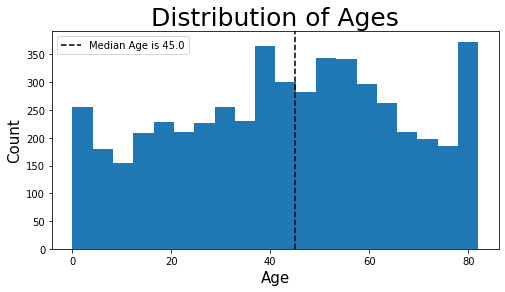

In [ ]:
## histogram of ages
plt.figure(figsize = (8,4))
plt.hist(df_ml['age'], bins = 'auto')

## including the median Age
median_age = df_ml['age'].median().round(2)

## titling and labeling
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of Ages', fontsize = 25)

plt.axvline(median_age, color = 'black', linestyle = '--', label = f'Median Age is {median_age}')
plt.legend();

The histogram above is displaying the distribution of the 'age' variable.  The distribution is somewhate uniform with a few small peaks in values, and with ages ranging from very young (close to newborns) all the way to individuals just over 80, and with a median age of 45.

### **'bmi' histogram:**

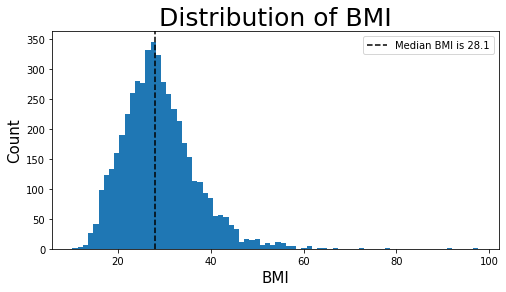

In [ ]:
## histogram of bmi
plt.figure(figsize = (8,4))
plt.hist(df_ml['bmi'], bins = 'auto')

## including the median Age
median_bmi = df_ml['bmi'].median().round(2)

## titling and labeling
plt.xlabel('BMI', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of BMI', fontsize = 25)

plt.axvline(median_bmi, color = 'black', linestyle = '--', label = f'Median BMI is {median_bmi}')
plt.legend();

The histogram above is displaying the distribution of the 'bmi' variable.  The distribution is fairly symmetric except for several larger outliers.

### **'avg_glucose_level' histogram:**

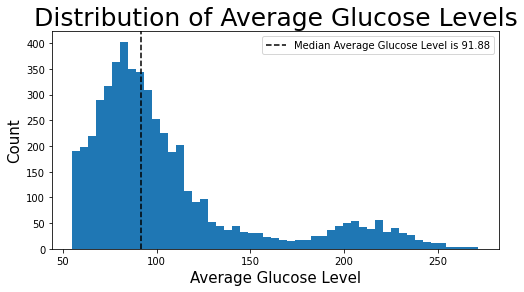

In [ ]:
## histogram of Average Glucose Level
plt.figure(figsize = (8,4))
plt.hist(df_ml['avg_glucose_level'], bins = 'auto')

## including the median Age
median_agl = df_ml['avg_glucose_level'].median().round(2)

## titling and labeling
plt.xlabel('Average Glucose Level', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of Average Glucose Levels', fontsize = 25)

plt.axvline(median_agl, color = 'black', linestyle = '--', label = f'Median Average Glucose Level is {median_agl}')
plt.legend();

The histogram above is displaying the distribution of the 'avg_glucose_level' variable.  The distribution is not symmetric, and has some skewness to the right.  The median is below 100 and the maximum value is above 250.

### **histogram compilation visual:**

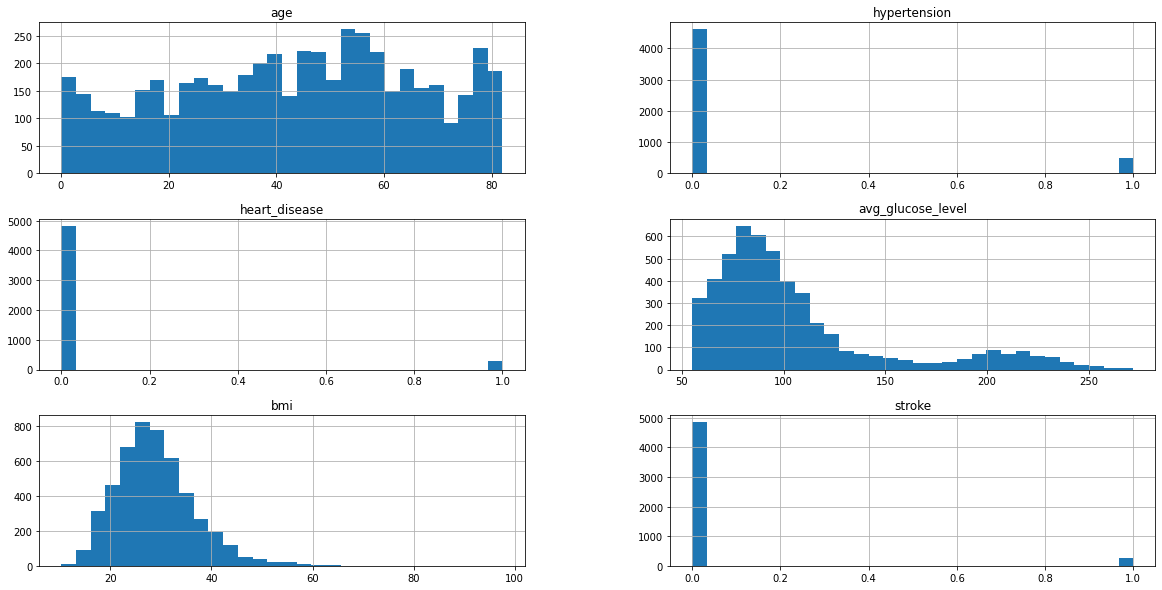

In [ ]:
df_ml.hist(bins=30, figsize=(20,10));

### **Check for outliers in 'avg-glucose_level', 'bmi', and 'ages'**

#### **.describe() for initial investigation**

In [ ]:
# common summary statistics
df_ml.describe(include = 'all').round(4)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5109,5109.0000,5109.0000,5109.0000,5109,5109,5109,5109.0000,4908.0000,5109,5109.0000
unique,2,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2994,NaN,NaN,NaN,3353,2924,2596,NaN,NaN,1892,NaN
mean,NaN,43.2300,0.0975,0.0540,NaN,NaN,NaN,106.1404,28.8946,NaN,0.0487
std,NaN,22.6136,0.2966,0.2261,NaN,NaN,NaN,45.2850,7.8543,NaN,0.2153
min,NaN,0.0800,0.0000,0.0000,NaN,NaN,NaN,55.1200,10.3000,NaN,0.0000
25%,NaN,25.0000,0.0000,0.0000,NaN,NaN,NaN,77.2400,23.5000,NaN,0.0000
50%,NaN,45.0000,0.0000,0.0000,NaN,NaN,NaN,91.8800,28.1000,NaN,0.0000
75%,NaN,61.0000,0.0000,0.0000,NaN,NaN,NaN,114.0900,33.1000,NaN,0.0000


### **Boxplots showing the outliers in the numerical columns:**

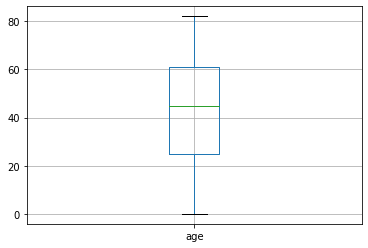

In [ ]:
df_ml.boxplot(column = 'age');

No outliers in the 'Age' column.

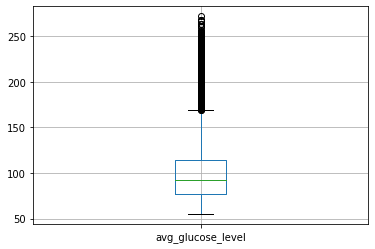

In [ ]:
df_ml.boxplot(column = 'avg_glucose_level');

Many outliers in the 'avg_glucose_level' column.

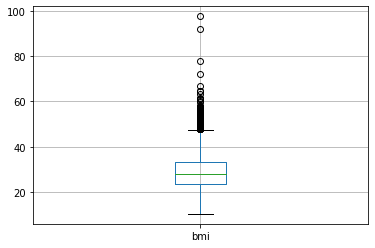

In [ ]:
df_ml.boxplot(column = 'bmi',);

Several outliers in the 'bmi' values.

The following function was adapted from https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/

In [ ]:
#create a function to find outliers using IQR

def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1
   print(f'The first quartile is: {q1:.2f}.')
   print(f'The third quartile is: {q3:.2f}.')
   print(f'The upper fence is {(q3+1.5*IQR):.02f}.')
   print(f'The lower fence is {(q1 - 1.5*IQR):.02f}.')

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

### Outlier information for 'age' column.

In [ ]:
outliers = find_outliers_IQR(df_ml['age'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

The first quartile is: 25.00.
The third quartile is: 61.00.
The upper fence is 115.00.
The lower fence is -29.00.
number of outliers: 0
max outlier value: nan
min outlier value: nan


### Outlier information for 'avg_glucose_level' column.

In [ ]:
outliers = find_outliers_IQR(df_ml['avg_glucose_level'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

The first quartile is: 77.24.
The third quartile is: 114.09.
The upper fence is 169.37.
The lower fence is 21.96.
number of outliers: 627
max outlier value: 271.74
min outlier value: 169.43


### Outlier information for 'bmi' column.

In [ ]:
outliers = find_outliers_IQR(df_ml['bmi'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))

The first quartile is: 23.50.
The third quartile is: 33.10.
The upper fence is 47.50.
The lower fence is 9.10.
number of outliers: 110
max outlier value: 97.6
min outlier value: 47.6


## **Project 2 - Part 3 Tasks:**

### **1. Identify any moderate or strong correlations between your target and your features and/or between one feature and another using a correlation heatmap.**

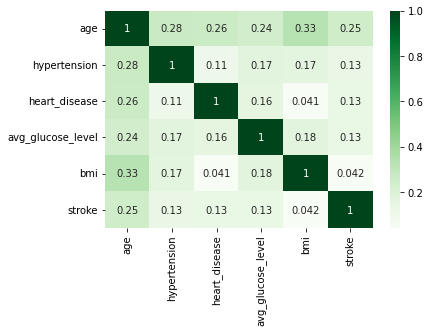

In [ ]:
# create the correlations
corr = df_ml.corr()

# plot the correlations created above in a heatmap
sns.heatmap(corr, cmap = 'Greens', annot = True);


There are no moderate or strong correlations between the target 'stroke' with any other feature.  The largest correlation value including the 'stroke' target is the correlation of 0.25 with 'age'.  However, the largest correlation value between any two features is 0.33 between the 'age' and 'bmi' features.  This is still not a moderate or strong correlation.

### **2. Create multivariate (multiple variables) exploratory visualizations to further understand your data and search for trends.**

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


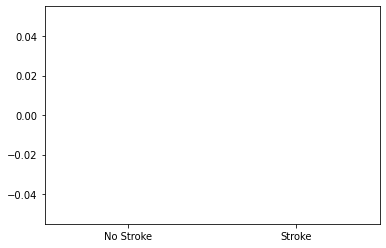

In [ ]:
## create a side by side boxplot of 'bmi' across 'stroke'
no_stroke_label = df_ml.loc[df_ml['stroke']== 0, 'bmi'].values
stroke_label = df_ml.loc[df_ml['stroke']== 1, 'bmi'].values
plt.boxplot([no_stroke_label, stroke_label], labels = ['No Stroke', 'Stroke']);


The distribution of 'bmi' of individuals with stroke is less spread out than the distribution of 'bmi' of individuals without stroke.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


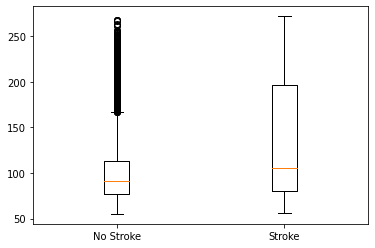

In [ ]:
## create a side by side boxplot of 'avg_glucose_level' across 'stroke'
no_stroke_label = df_ml.loc[df_ml['stroke']== 0, 'avg_glucose_level'].values
stroke_label = df_ml.loc[df_ml['stroke']== 1, 'avg_glucose_level'].values
plt.boxplot([no_stroke_label, stroke_label], labels = ['No Stroke', 'Stroke']);

The distribution of 'avg_glucose_level' of individuals with stroke is more spread out than the distribution of 'avg_glucose_level' of individuals without stroke.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


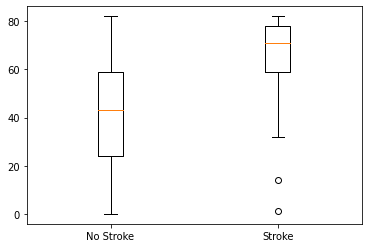

In [ ]:
## create a side by side boxplot of 'age' across 'stroke'
no_stroke_label = df_ml.loc[df_ml['stroke']== 0, 'age'].values
stroke_label = df_ml.loc[df_ml['stroke']== 1, 'age'].values
plt.boxplot([no_stroke_label, stroke_label], labels = ['No Stroke', 'Stroke']);

The distribution of 'age' of individuals with stroke is less spread out than the distribution of 'age' of individuals without stroke.  Overall, the values of the 'age' distribution are higher for those with stroke.

### **Scatterplot of Age and BMI:**

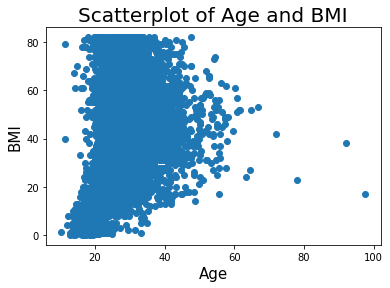

In [ ]:
## producing a scatterplot of 'age'' with 'bmi'
age_corr = df_ml['age'].values
bmi_corr = df_ml['bmi'].values
# stroke_corr = df['stroke'].values

plt.scatter(bmi_corr, age_corr)

## titles and labels
plt.title('Scatterplot of Age and BMI', fontsize = 20)
plt.ylabel('BMI', fontsize = 15)
plt.xlabel('Age', fontsize = 15);


The correlation of 'age' and 'bmi' from the heatpmap earlier was 0.33.  This scatterplot supports that there does not appear to be a linear association between these two features. 

### **Scatterplot of Average Glucose Level and BMI:**

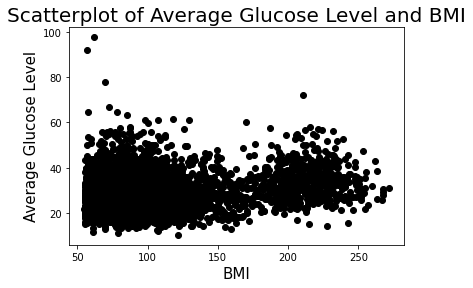

In [ ]:
## producing a scatterplot of 'ave_glucose_level'' with 'bmi'
avg_corr = df['avg_glucose_level'].values
bmi_corr = df['bmi'].values

plt.scatter(avg_corr, bmi_corr, c = 'k')

## titles and labels
plt.title('Scatterplot of Average Glucose Level and BMI', fontsize = 20)
plt.ylabel('Average Glucose Level', fontsize = 15)
plt.xlabel('BMI', fontsize = 15);


The correlation of 'average glucose' and 'bmi' from the heatpmap earlier was 0.17.  This scatterplot supports that there does not appear to be a linear association between these two features.

The following is a grouped bar chart exploring the 'hypertension' and 'stroke' features together.  There is an increased percentage of stroke incidence with the presence of hypertension.

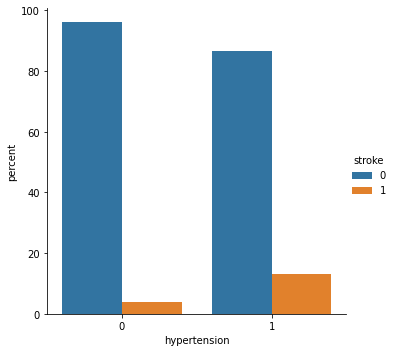

In [ ]:

x,y = 'hypertension', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'heart disease' and 'stroke' features together.  There is an increased percentage of stroke incidence with the presence of heart disease.

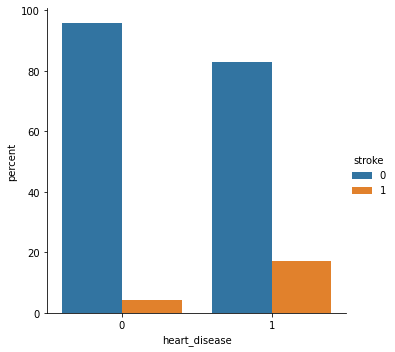

In [ ]:
x,y = 'heart_disease', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'ever married' and 'stroke' features together.  There is an increased percentage of stroke incidence with the presence of marriage.

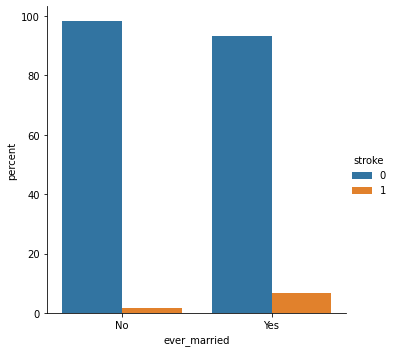

In [ ]:
x,y = 'ever_married', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'work_type' and 'stroke' features together.  There is an increased percentage of stroke incidence for those self-employed over other types of work.

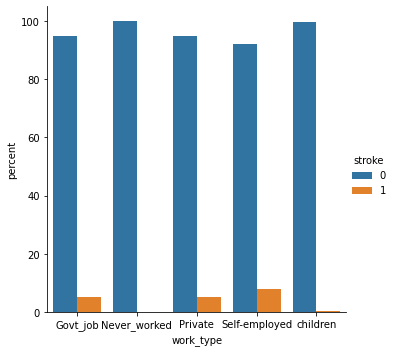

In [ ]:
x,y = 'work_type', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'smoking_status' and 'stroke' features together.  There is an increased percentage of stroke incidence for those who formerly smoked over other categories.

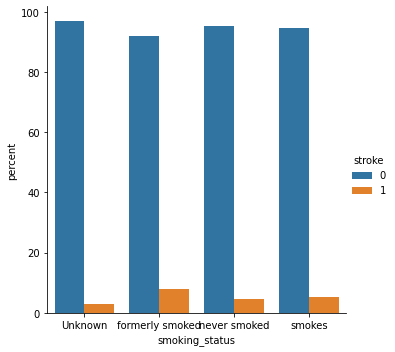

In [ ]:
x,y = 'smoking_status', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

The following is a grouped bar chart exploring the 'gender' and 'stroke' features together.  The stroke incidence is comparable for male and female genders.

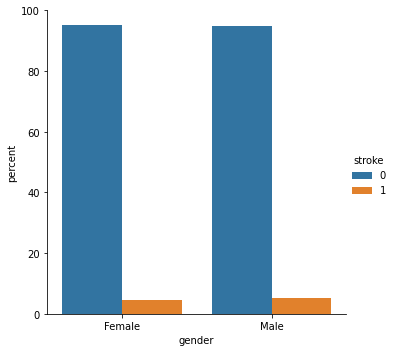

In [ ]:
x,y = 'gender', 'stroke'

(df_ml
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'));

## **Explanatory Visuals**

### **3.  Choose two visualizations from your analysis that demonstrate key trends you found that will be of interest to a stakeholder. These visuals should be reporting quality with titles, labels, and a short explanation of the trend. Be sure to explain in a text cell the finding associated with each visual. Both of these visualizations should be easily understood by a non-technical audience (Neither should be histograms, boxplots, or correlation plots).**

In [ ]:
# create a copy of the data frame for explanatory visuals
df_exp = df_ml.copy()
df_exp.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The next cell used to relabel legends and x-axis.

In [ ]:
df_exp['stroke'] = df_exp['stroke'].map({0: 'No Stroke', 1: 'Stroke'})
df_exp['hypertension'] = df_exp['hypertension'].map({0: 'No Hypertension', 1: 'Have Hypertension'})
df_exp['heart_disease'] = df_exp['heart_disease'].map({0: 'No Heart Disease', 1: 'Have Heart Disease'})
df_exp['ever_married'] = df_exp['ever_married'].map({'No': 'Never Married', 'Yes': 'Have Been Married'})

### **Grouped Bar Chart of Hypertension and Stroke:**

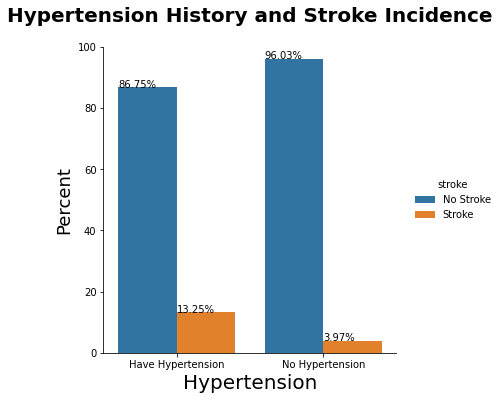

In [ ]:
x,y = 'hypertension', 'stroke'

df1 = df_exp.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1);
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## titles and labels
plt.title('Hypertension History and Stroke Incidence', fontsize = 20, fontweight='semibold', pad = 25)
plt.ylabel('Percent', fontsize = 18)
plt.xlabel('Hypertension', fontsize = 20);

The grouped bar chart above is a visualization of the association between the presence of hypertension and the presence of stroke in individuals.  There is more than triple the incidence of stroke for those individuals with hypertension.

### **Grouped Bar Chart of Heart Disease and Stroke:**

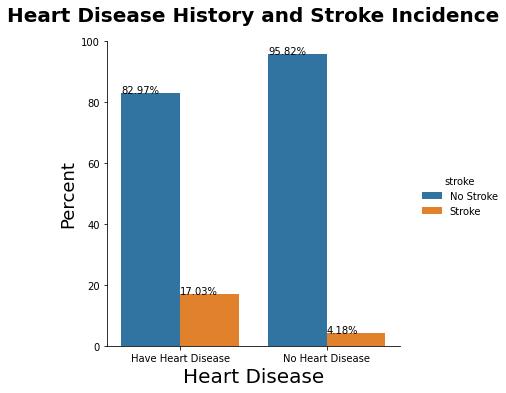

In [ ]:
# colors = ["#69b3a2", "#4374B3"]
# sns.set_palette(sns.color_palette(colors))

x,y = 'heart_disease', 'stroke'

df1 = df_exp.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## titles and labels
plt.title('Heart Disease History and Stroke Incidence', fontsize = 20, fontweight='semibold', pad = 20)
plt.ylabel('Percent', fontsize = 18)
plt.xlabel('Heart Disease', fontsize = 20);

The grouped bar chart above is a visualization of the association between the presence of heart disease and the presence of stroke in individuals.  There is more than four times the incidence of stroke for those individuals with heart disease.

### **Grouped Bar Chart of Marriage History and Stroke:**

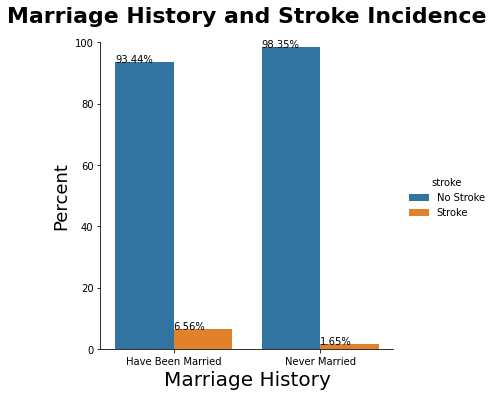

In [ ]:
# colors = ["#69b3a2", "#4374B3"]
# sns.set_palette(sns.color_palette(colors))

x,y = 'ever_married', 'stroke'

df1 = df_exp.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## titles and labels
plt.title('Marriage History and Stroke Incidence', fontsize = 22, fontweight='semibold', pad = 20)
plt.ylabel('Percent', fontsize = 18)
plt.xlabel('Marriage History', fontsize = 20);

The grouped bar chart above is a visualization of the association between an individual ever being married and the presence of stroke in the individual.  There is more than triple the incidence of stroke for those individuals who have ever been married.

The code for these two explanatory visualizations was adapted from https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group

## **Project 2 - Part 4 Tasks: Model Development Phase**
- Ensure that you complete the appropriate pre-processing steps.
- Try multiple models and tune the hyperparameters of each model to optimize model performance (include all models and hyperparameters tested in addition to the final model).
- Perform PCA or another feature engineering technique on your dataset to see how this impacts your results. (Try multiple techniques depending on data!).
- Evaluate model performance with appropriate metrics for the model.
- Choose "production" model and justify this decision.

## **Models, Prediction and Analysis**

## ***Pre_Processing***

In [ ]:
# perform the train/test split
X = df_ml.drop(columns = ['stroke'])
y = df_ml['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



In [ ]:
# Create preprocessor to impute and scale numeric data, and one-hot encode categorical data

# numeric impute and scale
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
numeric_pipe = make_pipeline(mean_imputer, scaler)

#categorical one hot encode
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#column selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# categorical and numeric tuples
cat_tuple = (ohe, cat_selector)
num_tuple = (numeric_pipe, num_selector)

# preprocessor
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')



In [ ]:
# check the balancing of target 'stroke'
df_ml['stroke'].value_counts(normalize = True)

0    0.951262
1    0.048738
Name: stroke, dtype: float64

In [ ]:
# check the balance of test data (baseline model)
y_test.value_counts(normalize = True)

0    0.937402
1    0.062598
Name: stroke, dtype: float64

- **There is a much lower incidence of individuals who have had a stroke. The data is imbalanced.  With this imbalance the recall score will be used to rank models created in an effort to lower false negatives, individuals with stroke who are misidentified as not having stroke.  Accuracy will also be considered in determing best model for overal prediction success.**

In [ ]:
# pca to retain 95% of the variance in the original features
pca = PCA(n_components = .95)

In [ ]:
# PCA Preprocessing Pipeline
pca_processing = make_pipeline(preprocessor, pca)

## ***Models and Optimization***

In [ ]:
# classification report function with confusion matrix plot
def eval_classification(model, X_train, X_test, y_train, y_test):
  print('Train Report:', classification_report(y_train, model.predict(X_train)))
  print('Test Report:', classification_report(y_test, model.predict(X_test)))

  cm = confusion_matrix(y_test, model.predict(X_test))

  plt.figure(figsize=(5, 5))
  heatmap(cm, annot=True)
  plt.xlabel('Predicted', fontsize=40)
  plt.ylabel('True', fontsize=40)
  plt.show();

### **Bagged Tree Model**

#### **Create and fit the bagged tree model:**

In [ ]:
%%time
# Create a model pipeline with the preprocessor and a Bagging Classifier model
bag_clf = BaggingClassifier(random_state=42)
bag_clf_pipe = make_pipeline(preprocessor, bag_clf)
bag_clf_pipe.fit(X_train, y_train) 

CPU times: user 127 ms, sys: 275 µs, total: 127 ms
Wall time: 137 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da9

Train Report:               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3662
           1       1.00      0.83      0.91       169

    accuracy                           0.99      3831
   macro avg       1.00      0.92      0.95      3831
weighted avg       0.99      0.99      0.99      3831

Test Report:               precision    recall  f1-score   support

           0       0.94      0.99      0.97      1198
           1       0.38      0.06      0.11        80

    accuracy                           0.94      1278
   macro avg       0.66      0.53      0.54      1278
weighted avg       0.91      0.94      0.91      1278



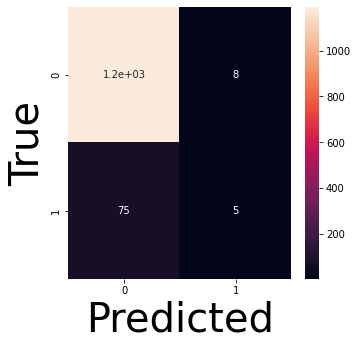

In [ ]:
eval_classification(bag_clf_pipe, X_train, X_test, y_train, y_test)

The recall score is 0.06 and the accuracy is 0.94.  A grid search will be used to hypertune parameters for increased recall score.

#### **Bagged Tree Tuning using GridSearchCV:**

In [ ]:
# instantiate a bagging tree model and create a parameter grid dictionary
bt_model = BaggingClassifier(random_state=42)

bt_model_pipe = make_pipeline(preprocessor, bt_model)
    
bt_model_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90a7f0>)])),
  ('baggingclassifier', BaggingClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='p

In [ ]:
# create a bagging tree parameter grid dictionary
bt_param_grid = {'baggingclassifier__max_features':range(1, 5),
                  'baggingclassifier__max_samples': range(1, 5),
                  'baggingclassifier__n_estimators': range(2, 20)}

In [ ]:
# instantiate bagging tree GridSearchCV Class
bt_grid_search = GridSearchCV(bt_model_pipe, bt_param_grid, scoring = 'recall')

In [ ]:
%%time
# fit bagging tree GridSeachCv on training data
bt_grid_search.fit(X_train, y_train)

CPU times: user 1min 8s, sys: 559 ms, total: 1min 9s
Wall time: 1min 9s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [ ]:
# examine bagging tree best parameters found by search
bt_grid_search.best_params_

{'baggingclassifier__max_features': 1,
 'baggingclassifier__max_samples': 1,
 'baggingclassifier__n_estimators': 2}

Train Report:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3662
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.91      0.96      0.93      3831

Test Report:               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

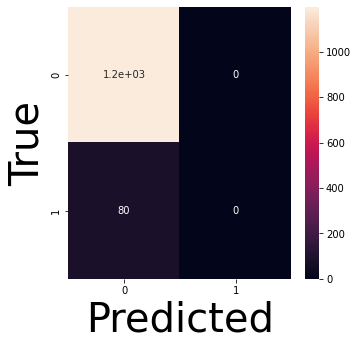

CPU times: user 294 ms, sys: 84.9 ms, total: 379 ms
Wall time: 288 ms


In [ ]:
%%time
# instantiate best bagging Tree using best estimator
bt_best_model = bt_grid_search.best_estimator_

# fit best bagging tree 
bt_best_model.fit(X_train, y_train)

eval_classification(bt_best_model, X_train, X_test, y_train, y_test)

The recall score is 0.00 and the accuracy is 0.94.  The grid search produced a set of best parameters that decreased recall.  PCA will be included to try to improve the grid search.

##### **Bagged Tree with PCA:**

In [ ]:
# pca preprocessor
bt_pca_preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')

In [ ]:
bt_pca = BaggingClassifier()

In [ ]:
bt_pca_pipe = make_pipeline(bt_pca_preprocessor, pca, bt_pca)
bt_pca_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90a7f0>)])),
  ('pca', PCA(n_components=0.95)),
  ('baggingclassifier', BaggingClassifier())],
 'verbose': False,
 'columntransformer': ColumnTran

In [ ]:
bt_grid = {'pca__n_components':[.5, .7, .9, None],
            'baggingclassifier__max_features':range(1, 5),
            'baggingclassifier__max_samples': range(1, 5),
            'baggingclassifier__n_estimators': range(2, 5)}

bt_grid = GridSearchCV(bt_pca_pipe, param_grid=bt_grid, scoring = 'recall')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
 

Train Report:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3662
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.91      0.96      0.93      3831

Test Report:               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



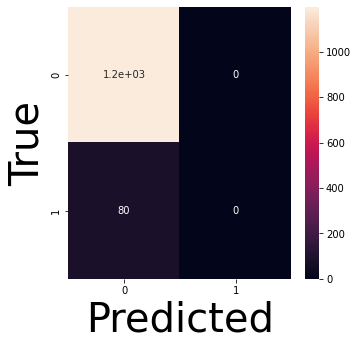

CPU times: user 58.2 s, sys: 54.9 s, total: 1min 53s
Wall time: 58.8 s


In [ ]:
%%time
bt_grid.fit(X_train, y_train)

eval_classification(bt_grid, X_train, X_test, y_train, y_test)

The recall score is still 0.00 and the accuracy is 0.94. PCA did not improve the model.

### **Logistic Regression**

The recall score is 0.01 and the accuracy is 0.94.  A grid search will be used to hypertune parameters for increased recall score.

#### **Create and fit the Logistic Regression model:**

In [ ]:
%%time
# Create a model pipeline with the preprocessor and a Logistic Regression model
log_reg = LogisticRegression()
log_pipe = make_pipeline(preprocessor, log_reg)
log_pipe.fit(X_train, y_train) 

CPU times: user 88.3 ms, sys: 55.5 ms, total: 144 ms
Wall time: 86.6 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da9

Train Report:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3662
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.91      0.96      0.93      3831

Test Report:               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


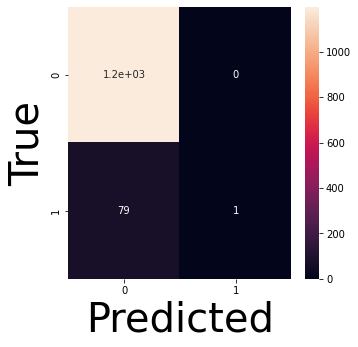

In [ ]:
eval_classification(log_pipe, X_train, X_test, y_train, y_test)

#### **Logistic Regression Tuning using GridSearchCV:**

In [ ]:
# instantiate logistic regression model and create a parameter grid dictionary
lr_model = LogisticRegression(random_state=42)

lr_model_pipe = make_pipeline(preprocessor, lr_model)

lr_model_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90a7f0>)])),
  ('logisticregression', LogisticRegression(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder=

In [ ]:
lr_param_grid = {'logisticregression__class_weight': [None, 'balanced'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'logisticregression__max_iter': [5, 100, 1000],
                  'logisticregression__solver': ['liblinear'],
                  'logisticregression__penalty':[None, 'l1', 'l2']}

In [ ]:
# instantiate logistic regression GridSearchCV Class
lr_grid_search = GridSearchCV(lr_model_pipe, lr_param_grid, scoring = 'recall')


In [ ]:
%%time
# fit GridSeachCv on training data
lr_grid_search.fit(X_train, y_train)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

CPU times: user 1min 18s, sys: 26.1 s, total: 1min 44s
Wall time: 1min 17s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [ ]:
# examine logistic regression best parameters found by search
lr_grid_search.best_params_

{'logisticregression__C': 0.0001,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__max_iter': 5,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

Train Report:               precision    recall  f1-score   support

           0       0.99      0.61      0.76      3662
           1       0.10      0.91      0.18       169

    accuracy                           0.63      3831
   macro avg       0.55      0.76      0.47      3831
weighted avg       0.95      0.63      0.73      3831

Test Report:               precision    recall  f1-score   support

           0       0.99      0.58      0.73      1198
           1       0.12      0.88      0.21        80

    accuracy                           0.59      1278
   macro avg       0.55      0.73      0.47      1278
weighted avg       0.93      0.59      0.69      1278



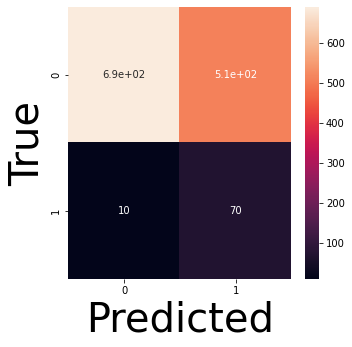

CPU times: user 313 ms, sys: 168 ms, total: 481 ms
Wall time: 318 ms


In [ ]:
%%time
lr_best_model = lr_grid_search.best_estimator_

lr_best_model.fit(X_train, y_train)

eval_classification(lr_best_model, X_train, X_test, y_train, y_test)


The recall score is 0.88 and the accuracy is 0.59.  The grid search produced a set of best parameters that increased recall.  PCA will be included to try to improve the grid search recall and accuracy scores.

##### **Logistic Regression with PCA**

In [ ]:
# pca preprocessor
lr_pca_preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')

In [ ]:
lr_pca = LogisticRegression()

In [ ]:
lr_pca_pipe = make_pipeline(lr_pca_preprocessor, pca, lr_pca)
lr_pca_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90a7f0>)])),
  ('pca', PCA(n_components=0.95)),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'columntransformer': ColumnTr

In [ ]:
lr_grid = {'pca__n_components':[.5, .7, .9, None],
            'logisticregression__class_weight': [None, 'balanced'],
            'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'logisticregression__max_iter': [10, 50, 100, 1000],
            'logisticregression__solver': ['liblinear'],
            'logisticregression__penalty':[None, 'l1', 'l2']}

lr_grid = GridSearchCV(lr_pca_pipe, param_grid=lr_grid, scoring = 'recall')

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

Train Report:               precision    recall  f1-score   support

           0       0.99      0.51      0.68      3662
           1       0.08      0.92      0.15       169

    accuracy                           0.53      3831
   macro avg       0.54      0.72      0.41      3831
weighted avg       0.95      0.53      0.65      3831

Test Report:               precision    recall  f1-score   support

           0       0.99      0.50      0.66      1198
           1       0.11      0.95      0.20        80

    accuracy                           0.53      1278
   macro avg       0.55      0.72      0.43      1278
weighted avg       0.94      0.53      0.64      1278



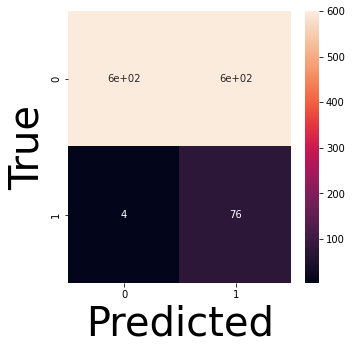

In [ ]:
lr_grid.fit(X_train, y_train)

eval_classification(lr_grid, X_train, X_test, y_train, y_test)

The recall score is 0.95 and the accuracy is 0.53.  The grid search with PCA produced a set of best parameters that increased the recall but decreased the accuracy.

### **LightGBM Model:**

In [ ]:
%%time
# Create a model pipeline with the preprocessor and a Light GBM classifier model
lgbm = LGBMClassifier()
lgbm_pipe = make_pipeline(preprocessor, lgbm)
lgbm_pipe.fit(X_train, y_train)

CPU times: user 253 ms, sys: 8.93 ms, total: 262 ms
Wall time: 152 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da9

Train Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3662
           1       1.00      0.96      0.98       169

    accuracy                           1.00      3831
   macro avg       1.00      0.98      0.99      3831
weighted avg       1.00      1.00      1.00      3831

Test Report:               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1198
           1       0.29      0.06      0.10        80

    accuracy                           0.93      1278
   macro avg       0.62      0.53      0.53      1278
weighted avg       0.90      0.93      0.91      1278



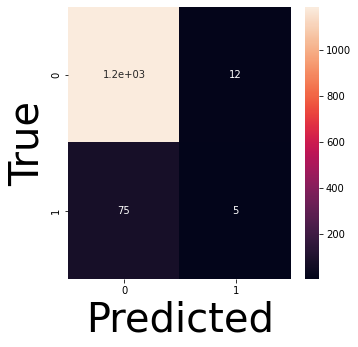

In [ ]:
eval_classification(lgbm_pipe, X_train, X_test, y_train, y_test)

The recall score is 0.06 and the accuracy is 0.94.  The grid search will be used to find the best hypertuned parameters to increase the recall score.

#### **Light GBM Tuning**

In [ ]:
# instantiate a light gbm model and create a parameter grid dictionary
lgbm_model = LGBMClassifier()

lgbm_model_pipe = make_pipeline(preprocessor, lgbm_model)

# lgbm_model_pipe.fit(X_train, y_train)

lgbm_model_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90a7f0>)])),
  ('lgbmclassifier', LGBMClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
        

In [ ]:
lgbm_param_grid = {'lgbmclassifier__max_depth':[1, 30, 50, 100],
                  'lgbmclassifier__num_leaves': [1, 50, 100],
                  'lgbmclassifier__n_estimators': [2, 50, 100, 500],
                  'lgbmclassifier__class_weight': [None, 'balanced']}


In [ ]:
# instantiate light gbm GridSearchCV Class
lgbm_grid_search = GridSearchCV(lgbm_model_pipe, lgbm_param_grid, scoring = 'recall')

In [ ]:
# fit light gbm GridSeachCv on training data
lgbm_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 997, in construct
    self._lazy_init(self.data, label=self.label,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 7

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('st

In [ ]:
# examine light gbm best parameters found by search
lgbm_grid_search.best_params_

{'lgbmclassifier__class_weight': 'balanced',
 'lgbmclassifier__max_depth': 1,
 'lgbmclassifier__n_estimators': 50,
 'lgbmclassifier__num_leaves': 50}

Train Report:               precision    recall  f1-score   support

           0       0.99      0.67      0.80      3662
           1       0.11      0.89      0.20       169

    accuracy                           0.68      3831
   macro avg       0.55      0.78      0.50      3831
weighted avg       0.95      0.68      0.78      3831

Test Report:               precision    recall  f1-score   support

           0       0.99      0.66      0.79      1198
           1       0.14      0.85      0.25        80

    accuracy                           0.68      1278
   macro avg       0.56      0.76      0.52      1278
weighted avg       0.93      0.68      0.76      1278



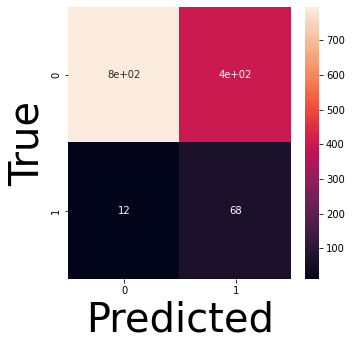

CPU times: user 399 ms, sys: 96.3 ms, total: 495 ms
Wall time: 309 ms


In [ ]:
%%time
lgbm_best_model = lgbm_grid_search.best_estimator_

lgbm_best_model.fit(X_train, y_train)

eval_classification(lgbm_best_model, X_train, X_test, y_train, y_test)


The recall score is 0.85 and the accuracy is 0.68.  The grid search produced a set of best parameters that increased recall.  PCA will be included to try to improve the grid search recall and accuracy.

##### **Light GBM with PCA**

In [ ]:
# pca preprocessor
light_pca_preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')

In [ ]:
light_pca = LGBMClassifier()

In [ ]:
light_pca_pipe = make_pipeline(light_pca_preprocessor, pca, light_pca)
light_pca_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90af70>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f86da90a7f0>)])),
  ('pca', PCA(n_components=0.95)),
  ('lgbmclassifier', LGBMClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransforme

In [ ]:
light_grid = {'pca__n_components':[.5, .7, .9, None],
                  'lgbmclassifier__max_depth':[1, 30, 50, 100],
                  'lgbmclassifier__num_leaves': [1, 50, 100],
                  'lgbmclassifier__n_estimators': [2, 50, 100, 500],
                  'lgbmclassifier__class_weight': [None, 'balanced']}

light_grid = GridSearchCV(light_pca_pipe, param_grid=light_grid, scoring = 'recall')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 997, in construct
    self._lazy_init(self.data, label=self.label,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 

Train Report:               precision    recall  f1-score   support

           0       0.99      0.53      0.69      3662
           1       0.08      0.92      0.15       169

    accuracy                           0.55      3831
   macro avg       0.54      0.73      0.42      3831
weighted avg       0.95      0.55      0.67      3831

Test Report:               precision    recall  f1-score   support

           0       0.99      0.51      0.67      1198
           1       0.11      0.90      0.19        80

    accuracy                           0.53      1278
   macro avg       0.55      0.70      0.43      1278
weighted avg       0.93      0.53      0.64      1278



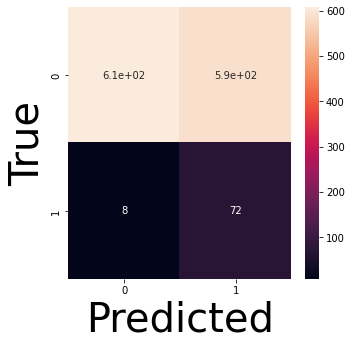

CPU times: user 18min 14s, sys: 2min 27s, total: 20min 42s
Wall time: 10min 59s


In [ ]:
%%time 
light_grid.fit(X_train, y_train)

eval_classification(light_grid, X_train, X_test, y_train, y_test)

The recall score is 0.90 and the accuracy is 0.53.  The grid search with PCA produced a set of best parameters that increased recall but reduced accuracy significantly from 0.68 to 0.53. 

# **Production Model:**

The model chosen for production will be the LightGBM Model with hypertuned parameters from using GridSearchCV.  The recall score for this was 0.85 with an accuracy of 0.68.  This model was chosen to reduce the incidence of predicting an individual does not have stroke when in fact they do.  This LightGBM model also had an accuracy of 0.68, better at predicting overall than other models of comparable recall scores.  

In [ ]:
best_model = light_grid

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 997, in construct
    self._lazy_init(self.data, label=self.label,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 

Train Report:               precision    recall  f1-score   support

           0       0.99      0.53      0.69      3662
           1       0.08      0.92      0.15       169

    accuracy                           0.55      3831
   macro avg       0.54      0.73      0.42      3831
weighted avg       0.95      0.55      0.67      3831

Test Report:               precision    recall  f1-score   support

           0       0.99      0.51      0.67      1198
           1       0.11      0.90      0.19        80

    accuracy                           0.53      1278
   macro avg       0.55      0.70      0.43      1278
weighted avg       0.93      0.53      0.64      1278



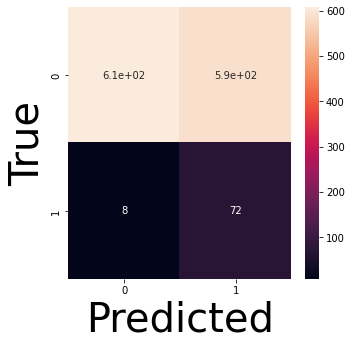

CPU times: user 18min 18s, sys: 2min 30s, total: 20min 48s
Wall time: 11min 3s


In [ ]:
%%time 
best_model.fit(X_train, y_train)

eval_classification(best_model, X_train, X_test, y_train, y_test)

In [ ]:
# examine light gbm best parameters found by search
best_model.best_params_

{'lgbmclassifier__class_weight': 'balanced',
 'lgbmclassifier__max_depth': 1,
 'lgbmclassifier__n_estimators': 2,
 'lgbmclassifier__num_leaves': 50,
 'pca__n_components': 0.5}

Best Model: **LightGBM:**

- **Tuned parameters:**
- Class Weight: 'balanced'
- max_depth: 1
- n_estimators: 2
- num_leaves: 50
- pca_n_components: 0.5

- **Scores:**
- Recall: 0.85
- Accuracy: 0.68
- Precision: 0.11
- F1-score: 0.19